In [1]:
import numpy
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing import sequence
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import sequence
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

numpy.random.seed(7)


Using TensorFlow backend.


In [2]:
import numpy as np

np.random.seed(7)
resDir = "C:/Users/bhati/Desktop/Stack Exchange Research/results/"

import csv
def readcsv(name):
    with open(resDir+name+'.csv','r') as f:
        reader = csv.reader(f)
        next(reader)
        lst = list(reader)
        npa = np.asarray(lst, dtype=np.float32)
    return npa

X_train = readcsv('X_train1')
X_test = readcsv('X_test1')
y_train = readcsv('y_train1') 
y_test = readcsv('y_test1')

# Merging the test and the train from previous csvs
X = np.concatenate((X_test, X_train), axis = 0)
Y = np.concatenate((y_test, y_train), axis = 0)

In [3]:
print(X.shape, X_test.shape, X_train.shape)
print ((X_test[1]).shape)
print (np.amax(X_test[1]))
print (X_test.shape)

(18257, 333) (5478, 333) (12779, 333)
(333,)
0.6600604
(5478, 333)


# Grid Search for optimal hyperparameters

In [7]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.utils import np_utils
from keras.callbacks import Callback

def auc_roc(y_true, y_pred):
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

def createModel():
    model = Sequential()
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', auc_roc])
    # print(model.summary())
    return model


# model = createModel()

# 10 fold validation

In [10]:
numpy.random.seed(7)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
testacc = []
testloss = []
testauc = []

valacc = []
valloss = []
valauc = []

acc = []
auc = []
loss = []

for train, test in kfold.split(X, Y):
    # create model
    model = createModel()
    hist = model.fit(X[train], Y[train], epochs=50, validation_split= 0.3, batch_size=64, verbose=0)
    # validation saving
    valacc.append(hist.history['val_acc'])
    valloss.append(hist.history['val_loss'])
    valauc.append(hist.history['val_auc_roc'])
    
    # training
    acc.append(hist.history['acc'])
    loss.append(hist.history['loss'])
    auc.append(hist.history['auc_roc'])
    
    # testing set
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    
    # testing saving
    testloss.append(scores[0] * 100)
    testacc.append(scores[1] * 100)
    testauc.append(scores[2] * 100)

auc_roc: 76.81%
auc_roc: 77.04%
auc_roc: 76.90%
auc_roc: 76.82%
auc_roc: 76.77%
auc_roc: 76.97%
auc_roc: 76.74%
auc_roc: 76.91%
auc_roc: 76.72%
auc_roc: 77.24%


In [36]:
def val(item):
    tmp = []
    for i, val in enumerate(item):
         tmp.append(np.mean(val))
    return tmp
vacc = val(valacc)
vauc = val(valauc)
vlos = val(valloss)

tacc = val(acc)
tauc = val(auc)
tlos = val(loss)

In [41]:
print ("-----testing-----")
print("acc: ",(numpy.mean(testacc), numpy.std(testacc)))
print("loss: ", (numpy.mean(testloss), numpy.std(testloss)))
print("auc: ", (numpy.mean(testauc), numpy.std(testauc)))

print ("\n-----validation-----")
print("acc: " , (numpy.mean(vacc), numpy.std(vacc)))
print("loss: ", (numpy.mean(vlos), numpy.std(vlos)))
print("auc: ", (numpy.mean(vauc), numpy.std(vauc)))


print ("\n-----training-----")
print("acc: ", (numpy.mean(tacc), numpy.std(tacc)))
print("loss: ", (numpy.mean(tlos), numpy.std(tlos)))
print("auc: ", (numpy.mean(tauc), numpy.std(tauc)))

-----testing-----
acc:  (71.03031103242361, 1.2673925505815744)
loss:  (55.66530634421861, 1.064951127408538)
auc:  (76.89304366327426, 0.15183611133053967)

-----validation-----
acc:  (0.7050292089249492, 0.0016826293713969379)
loss:  (0.5656089186830162, 0.0024168067716318076)
auc:  (0.7536746093699221, 0.0014206068707579768)

-----training-----
acc:  (0.7156851775626718, 0.0011575252621079952)
loss:  (0.5511156967522256, 0.0014095678661439337)
auc:  (0.7519944976918863, 0.0014412139305901837)


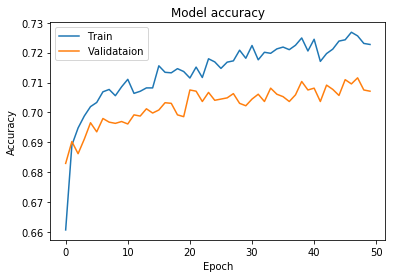

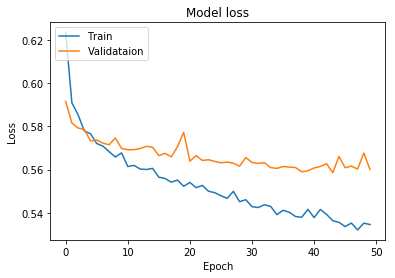

In [27]:
# Plot training & validation accuracy values for last model
fig, ax = plt.subplots()
ax.plot(hist.history['acc'])
ax.plot(hist.history['val_acc'])
ax.set_title('Model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validataion'], loc='upper left')
fig.savefig("accuracy.pdf", bbox_inches='tight')

# Plot training & validation loss values
fig, ax = plt.subplots()
ax.plot(hist.history['loss'])
ax.plot(hist.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validataion'], loc='upper left')
fig.savefig("loss.pdf", bbox_inches='tight')


# Baseline

In [ ]:
numpy.random.seed(7)
auc_rf = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
for train, test in kfold.split(X, Y):
    rf  =  RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=0)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    auc_rf.append(metrics.auc(y_test, pred))
    

In [ ]:
from scipy.stats import ranksums
print (ranksums(acc_rf, auc_roc))

#the comparison is statistically significant

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf  =  RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, pred)))

C:\Users\bhati\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Accuracy: 0.6915


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


In [46]:
#feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 303 (0.086344)
2. feature 302 (0.061684)
3. feature 331 (0.055418)
4. feature 332 (0.053958)
5. feature 304 (0.053872)
6. feature 328 (0.053034)
7. feature 311 (0.040462)
8. feature 300 (0.037028)
9. feature 327 (0.035970)
10. feature 316 (0.034223)
11. feature 324 (0.032527)
12. feature 307 (0.031655)
13. feature 319 (0.030822)
14. feature 315 (0.029157)
15. feature 323 (0.028643)
16. feature 318 (0.028397)
17. feature 320 (0.027109)
18. feature 312 (0.027028)
19. feature 326 (0.026848)
20. feature 310 (0.025931)
21. feature 321 (0.025386)
22. feature 325 (0.022625)
23. feature 317 (0.022541)
24. feature 322 (0.021563)
25. feature 313 (0.018054)
26. feature 305 (0.016889)
27. feature 309 (0.016824)
28. feature 308 (0.016675)
29. feature 314 (0.014677)
30. feature 301 (0.011823)
31. feature 330 (0.007152)
32. feature 306 (0.004250)
33. feature 329 (0.001425)
34. feature 102 (0.000000)
35. feature 96 (0.000000)
36. feature 97 (0.000000)
37. feature 98 (0.0000